# Neural network Homework 1  \   Q4 part B- Classification (and Bonus Implementation)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

### Part A : increasing trainingset size from 5% to 100% each step 15%

In [2]:
# Ensure reproducibility
random_state = 3
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)




class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = FullyConnectedNN().to(device)

class Training_FCN:
    def __init__(self, model, device='cpu', epochs=1000, learning_rate=0.01,random_state=4):
        self.model = model.to(device)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.device = device
        self.random_state = random_state
    def fit(self,train_loader, test_loader):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for images, labels in self.train_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(self.train_loader)
            train_accuracy = 100 * correct / total
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)

            # Evaluation on test set
            test_loss, test_accuracy = self.evaluate()
            self.test_losses.append(test_loss)
            self.test_accuracies.append(test_accuracy)

            print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.2f}%')

        return self

    def evaluate(self):
        self.model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = nn.CrossEntropyLoss()(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss /= len(self.test_loader)
        test_accuracy = 100 * correct / total
        return test_loss, test_accuracy


import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch import nn, optim

# Assuming the classes FullyConnectedNN and Training_FCN are already defined

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Initialize storage for metrics
best_train_losses = []
corresponding_test_losses = []
best_train_accuracies = []
corresponding_test_accuracies = []
training_sizes = []
percentages = [5, 20, 35, 50, 65, 80, 95, 100]  # Direct percentages

# Iterate over subsets of the training dataset
for percentage in percentages:
    subset_size = int((percentage / 100.0) * len(train_dataset))
    training_sizes.append(percentage)  # Store the percentage for plotting directly

    subset_indices = torch.randperm(len(train_dataset))[:subset_size]
    train_subset = Subset(train_dataset, subset_indices)
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    model = FullyConnectedNN().to(device)
    print(f'Training with {percentage}% of the training set, subset size: {subset_size}')
    training = Training_FCN(model, device=device, epochs=9, learning_rate=0.0025)  #epoches =10 and learning_rate= 0.0025 random state= 3
    training.fit(train_loader, test_loader)

    # Find the epoch with the best (minimum) training loss
    min_loss_epoch = training.train_losses.index(min(training.train_losses))

    # Append best training loss and its corresponding test loss
    best_train_losses.append(training.train_losses[min_loss_epoch])
    corresponding_test_losses.append(training.test_losses[min_loss_epoch])

    # Append accuracy at the epoch of the best training loss
    best_train_accuracies.append(training.train_accuracies[min_loss_epoch])
    corresponding_test_accuracies.append(training.test_accuracies[min_loss_epoch])


100%|██████████| 9912422/9912422 [00:00<00:00, 163822571.25it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 22186024.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 196100927.12it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20528587.03it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training with 5% of the training set, subset size: 3000
Epoch 1: Train Loss = 1.0226, Train Accuracy = 65.73%, Test Loss = 0.4933, Test Accuracy = 84.15%
Epoch 2: Train Loss = 0.4419, Train Accuracy = 86.40%, Test Loss = 0.4317, Test Accuracy = 86.76%
Epoch 3: Train Loss = 0.3094, Train Accuracy = 90.40%, Test Loss = 0.4166, Test Accuracy = 87.64%
Epoch 4: Train Loss = 0.2606, Train Accuracy = 91.57%, Test Loss = 0.3182, Test Accuracy = 90.07%
Epoch 5: Train Loss = 0.2140, Train Accuracy = 93.43%, Test Loss = 0.2999, Test Accuracy = 91.06%
Epoch 6: Train Loss = 0.1711, Train Accuracy = 94.57%, Test Loss = 0.3171, Test Accuracy = 90.58%
Epoch 7: Train Loss = 0.1547, Train Accuracy = 95.47%, Test Loss = 0.3460, Test Accuracy = 89.81%
Epoch 8: Train Loss = 0.1190, Train Accuracy = 96.27%, Test Loss = 0.2955, Test Accuracy = 91.10%
Epoch 9: Train Loss = 0.1029, Train Accuracy = 96.47%, Test Loss = 0.2763, Test Accur

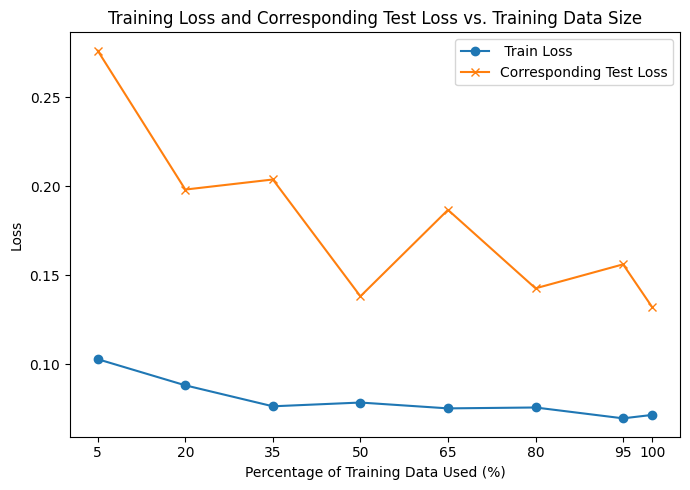

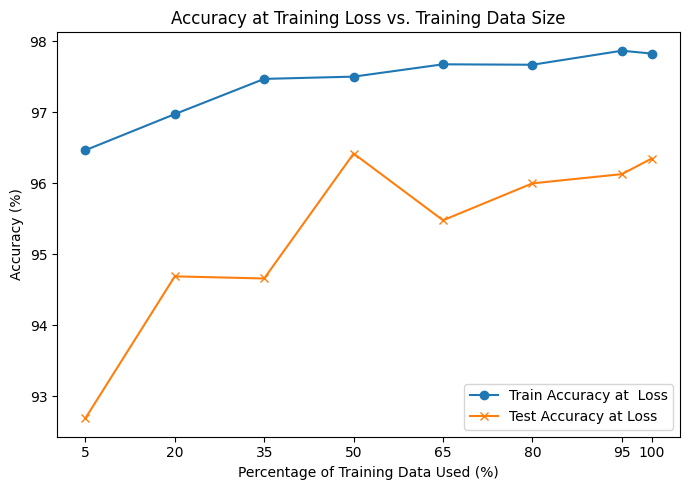

In [3]:
# Plotting
plt.figure(figsize=(7, 5))

# Loss plot
plt.plot(training_sizes, best_train_losses, '-o', label=' Train Loss')
plt.plot(training_sizes, corresponding_test_losses, '-x', label='Corresponding Test Loss')
plt.title('Training Loss and Corresponding Test Loss vs. Training Data Size')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Loss')
plt.legend()
plt.xticks(percentages)
plt.tight_layout()
plt.show()

# Accuracy plot
plt.figure(figsize=(7, 5))
plt.plot(training_sizes, best_train_accuracies, '-o', label='Train Accuracy at  Loss')
plt.plot(training_sizes, corresponding_test_accuracies, '-x', label='Test Accuracy at Loss')
plt.title('Accuracy at Training Loss vs. Training Data Size')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Accuracy (%)')
plt.xticks(percentages)
plt.legend()
plt.tight_layout()
plt.show()


## Part B : increasing layers from 3 to 20

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Ensure reproducibility
random_state = 6 #6 is good 10 epoch and learning rate 0.001
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class FullyConnectedNN(nn.Module):
    def __init__(self, num_layers=3):
        super(FullyConnectedNN, self).__init__()
        layers = [nn.Linear(28*28, 512)]

        if num_layers == 3:
            layers.append(nn.ReLU())
            layers.append(nn.Linear(512, 256))
            layers.append(nn.ReLU())
            layers.append(nn.Linear(256, 10))
            self.layers = nn.Sequential(*layers)

        k=400
        layers.append(nn.ReLU())
        layers.append(nn.Linear(512, 400))
        if num_layers > 3:
            for i in range(1, num_layers - 2):
                step=int((400-64)/(num_layers-2))
                s=400-step*i
                layers.append(nn.ReLU())
                layers.append(nn.Linear(k,s))
                k=s
            layers.append(nn.ReLU())
            layers.append(nn.Linear(k, 10))
            self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28*28)
        for layer in self.layers:
            x = layer(x)
        return x


class Training_FCN:
    def __init__(self, model, device='cpu', epochs=10, learning_rate=0.01):
        self.model = model.to(device)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.device = device

    def fit(self, train_loader, test_loader):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for images, labels in self.train_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(self.train_loader)
            train_accuracy = 100 * correct / total
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)

            self.model.eval()
            test_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in self.test_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    outputs = self.model(images)
                    loss = criterion(outputs, labels)

                    test_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            test_loss /= len(self.test_loader)
            test_accuracy = 100 * correct / total
            self.test_losses.append(test_loss)
            self.test_accuracies.append(test_accuracy)

            print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.2f}%')

        return self

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

num_layers_range = range(3, 21)
best_train_losses = []
corresponding_test_losses = []
best_train_accuracies = []
corresponding_test_accuracies = []

for num_layers in num_layers_range:
    model = FullyConnectedNN(num_layers=num_layers).to(device)
    print(f'Training model with {num_layers} layers')
    trainer = Training_FCN(model, device=device, epochs=10, learning_rate=0.0007)
    trainer.fit(train_loader, test_loader)

    # Find the epoch with the best (minimum) training loss
    min_loss_epoch = trainer.train_losses.index(min(trainer.train_losses))
    best_train_losses.append(trainer.train_losses[min_loss_epoch])
    corresponding_test_losses.append(trainer.test_losses[min_loss_epoch])
    best_train_accuracies.append(trainer.train_accuracies[min_loss_epoch])
    corresponding_test_accuracies.append(trainer.test_accuracies[min_loss_epoch])


Training model with 3 layers
Epoch 1: Train Loss = 0.2597, Train Accuracy = 92.61%, Test Loss = 0.1134, Test Accuracy = 96.31%
Epoch 2: Train Loss = 0.0974, Train Accuracy = 97.02%, Test Loss = 0.0778, Test Accuracy = 97.53%
Epoch 3: Train Loss = 0.0620, Train Accuracy = 98.08%, Test Loss = 0.0768, Test Accuracy = 97.72%
Epoch 4: Train Loss = 0.0439, Train Accuracy = 98.59%, Test Loss = 0.0698, Test Accuracy = 97.66%
Epoch 5: Train Loss = 0.0330, Train Accuracy = 98.91%, Test Loss = 0.0751, Test Accuracy = 97.76%
Epoch 6: Train Loss = 0.0266, Train Accuracy = 99.12%, Test Loss = 0.0863, Test Accuracy = 97.64%
Epoch 7: Train Loss = 0.0198, Train Accuracy = 99.39%, Test Loss = 0.0736, Test Accuracy = 97.93%
Epoch 8: Train Loss = 0.0174, Train Accuracy = 99.44%, Test Loss = 0.0787, Test Accuracy = 97.99%
Epoch 9: Train Loss = 0.0135, Train Accuracy = 99.56%, Test Loss = 0.0806, Test Accuracy = 97.97%
Epoch 10: Train Loss = 0.0143, Train Accuracy = 99.54%, Test Loss = 0.0841, Test Accuracy

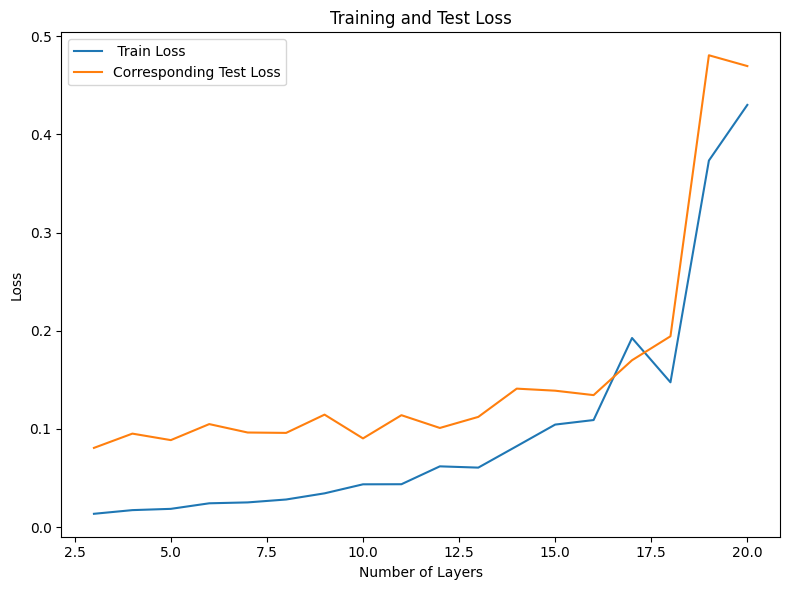

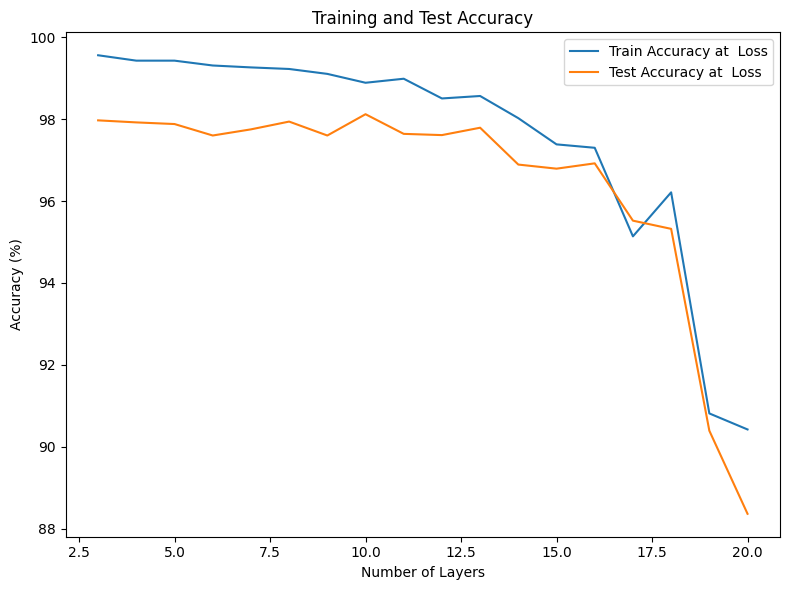

In [6]:
# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(num_layers_range, best_train_losses, label=' Train Loss')
plt.plot(num_layers_range, corresponding_test_losses, label='Corresponding Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Number of Layers')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()
plt.figure(figsize=(8, 6))
plt.plot(num_layers_range, best_train_accuracies, label='Train Accuracy at  Loss')
plt.plot(num_layers_range, corresponding_test_accuracies, label='Test Accuracy at  Loss')
plt.title('Training and Test Accuracy')
plt.xlabel('Number of Layers')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()


## Part C : Bonus Implementation

In [5]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

Epoch 1, Train Loss: 0.0887, Train Accuracy: 97.57%, Test Loss: 0.0369, Test Accuracy: 99.02%
Epoch 2, Train Loss: 0.0301, Train Accuracy: 99.11%, Test Loss: 0.0222, Test Accuracy: 99.22%
Epoch 3, Train Loss: 0.0202, Train Accuracy: 99.36%, Test Loss: 0.0196, Test Accuracy: 99.39%
Epoch 4, Train Loss: 0.0146, Train Accuracy: 99.53%, Test Loss: 0.0133, Test Accuracy: 99.52%
Epoch 5, Train Loss: 0.0084, Train Accuracy: 99.74%, Test Loss: 0.0148, Test Accuracy: 99.52%


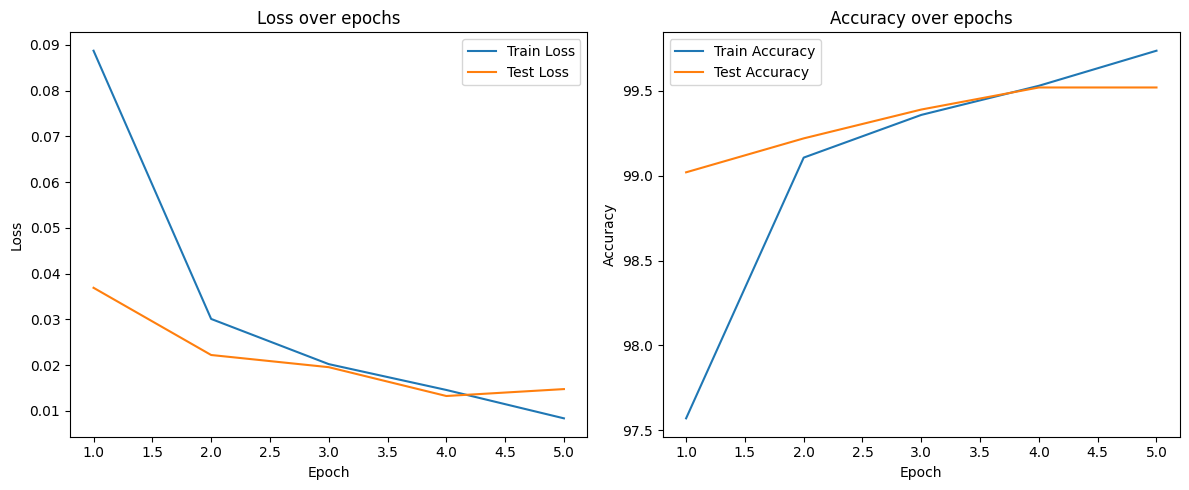

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import timm
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import StepLR


transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])


train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)


class EfficientNetMNIST(nn.Module):
    def __init__(self):
        super(EfficientNetMNIST, self).__init__()
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=10)

    def forward(self, x):
        return self.efficientnet(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetMNIST().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

def evaluate(model, device, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100. * correct / total
    return test_loss, test_accuracy


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

epochs = 5
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, device, test_loader, criterion)
    scheduler.step()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(np.arange(1, epochs + 1), test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(np.arange(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
